https://www.kaggle.com/aryaprince/getting-started-with-object-detection-with-pytorch/?

## EDA

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from PIL import Image
import cv2
import os
import re

In [19]:
data_path = '../../data/wheat_detection/'

df_train = pd.read_csv(data_path + 'train.csv')
df_sub = pd.read_csv(data_path + 'sample_submission.csv')

In [20]:
df_train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [21]:
df_train = df_train.drop(columns=['width', 'height', 'source'])
df_train.head()

,image_id,bbox
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]"
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]"
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]"
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]"
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]"


In [22]:
len(df_train['image_id'].unique())

3373

In [23]:
aa = df_train['bbox'].iloc[0]
aa

'[834.0, 222.0, 56.0, 36.0]'

In [24]:
bbox_list = df_train['bbox']
x1, y1, x2, y2 = [], [], [], []
for b in bbox_list:
    bbox = re.findall('([0-9]+[.]?[0-9]*)', b)
    x1.append(float(bbox[0]))
    y1.append(float(bbox[1]))
    x2.append(float(bbox[0]) + float(bbox[2]))
    y2.append(float(bbox[1]) + float(bbox[3]))

df_train['x1'] = x1
df_train['y1'] = y1
df_train['x2'] = x2
df_train['y2'] = y2

df_train.head()

,image_id,bbox,x1,y1,x2,y2
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]",834.0,222.0,890.0,258.0
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]",226.0,548.0,356.0,606.0
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]",377.0,504.0,451.0,664.0
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]",834.0,95.0,943.0,202.0
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]",26.0,144.0,150.0,261.0


In [25]:
image_ids = df_train['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

df_valid = df_train[df_train['image_id'].isin(valid_ids)]
df_train = df_train[df_train['image_id'].isin(train_ids)]

In [26]:
df_valid.head()

,image_id,bbox,x1,y1,x2,y2
122787,bbce58f71,"[430.0, 0.0, 142.0, 75.0]",430.0,0.0,572.0,75.0
122788,bbce58f71,"[255.0, 377.0, 100.0, 69.0]",255.0,377.0,355.0,446.0
122789,bbce58f71,"[788.0, 634.0, 146.0, 77.0]",788.0,634.0,934.0,711.0
122790,bbce58f71,"[344.0, 836.0, 102.0, 110.0]",344.0,836.0,446.0,946.0
122791,bbce58f71,"[217.0, 694.0, 107.0, 85.0]",217.0,694.0,324.0,779.0


In [27]:
df_train.head()

,image_id,bbox,x1,y1,x2,y2
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]",834.0,222.0,890.0,258.0
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]",226.0,548.0,356.0,606.0
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]",377.0,504.0,451.0,664.0
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]",834.0,95.0,943.0,202.0
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]",26.0,144.0,150.0,261.0


(-0.5, 1023.5, 1023.5, -0.5)

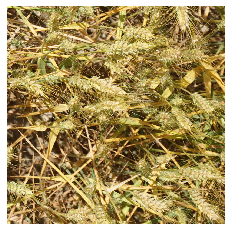

In [28]:
import glob
image_list = glob.glob(data_path + 'train/*.jpg')
sample = Image.open(image_list[0])
plt.imshow(sample)
plt.axis('off')

## Dataset

In [29]:
class wheatdataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        
        self.image_ids = self.dataframe['image_id'].unique()
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        img = Image.open(self.image_dir + image_id + '.jpg')
        img = np.array(img) / 255.
      
    
        img = cv2.imread(self.image_dir + image_id + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        
        if self.transform:
            img = self.transform(img)
            
        
        boxes = self.dataframe.loc[self.dataframe['image_id'] == image_id, ['x1','y1','x2','y2']]
        boxes = np.array(boxes)
        boxes = torch.from_numpy(boxes).type(torch.float32)
        
        labels = torch.ones((boxes.shape[0])).type(torch.int64)
        
        targets = {}
        targets['boxes'] = boxes
        targets['labels'] = labels
        
        return img.type(torch.FloatTensor), targets
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [30]:
TRAIN_DIR = '../../data/wheat_detection/train/'
TEST_DIR = '../../data/wheat_detection/test/'

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = wheatdataset(df_train, TRAIN_DIR, transform=transform)
print(len(train_data))
trainloader = DataLoader(train_data, batch_size=1, collate_fn=collate_fn)
iter(trainloader).next()

2708


((tensor([[[0.1020, 0.1176, 0.1412,  ..., 0.2824, 0.2902, 0.2902],
           [0.0941, 0.1059, 0.1294,  ..., 0.2667, 0.2667, 0.2667],
           [0.0824, 0.0941, 0.1137,  ..., 0.2549, 0.2549, 0.2549],
           ...,
           [0.2196, 0.2196, 0.2196,  ..., 0.8667, 0.8784, 0.8667],
           [0.2353, 0.2314, 0.2275,  ..., 0.7882, 0.8078, 0.8196],
           [0.2471, 0.2431, 0.2392,  ..., 0.7176, 0.7294, 0.7529]],
  
          [[0.0941, 0.1098, 0.1333,  ..., 0.3804, 0.3804, 0.3804],
           [0.0863, 0.0980, 0.1216,  ..., 0.3608, 0.3647, 0.3647],
           [0.0745, 0.0863, 0.1059,  ..., 0.3569, 0.3569, 0.3569],
           ...,
           [0.2196, 0.2196, 0.2196,  ..., 0.8157, 0.8314, 0.8275],
           [0.2353, 0.2314, 0.2275,  ..., 0.7373, 0.7608, 0.7804],
           [0.2471, 0.2431, 0.2392,  ..., 0.6667, 0.6824, 0.7137]],
  
          [[0.0980, 0.1137, 0.1373,  ..., 0.2667, 0.2706, 0.2667],
           [0.0902, 0.1020, 0.1255,  ..., 0.2588, 0.2510, 0.2510],
           [0.0784, 0.

In [31]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

images, targets = iter(trainloader).next()
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


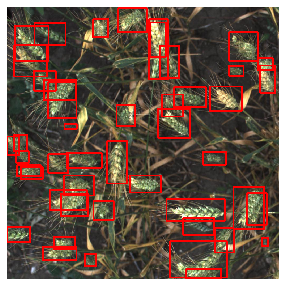

In [33]:
boxes = targets[0]['boxes'].cpu().numpy()
sample = images[0].permute(1,2,0).numpy()

fig, ax = plt.subplots(1, figsize=(5,5))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (255, 0, 0),
                  6)
    
ax.set_axis_off()
plt.imshow(sample)

## Model

In [34]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
model = fasterrcnn_resnet50_fpn(pretrained=False)

num_classes = 2 # background & wheat

in_features = model.roi_heads.box_predictor.cls_score.in_features


model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

## Sample

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [41]:
#model.load_state_dict(torch.load('../../data/wheat_detection/fasterrcnn_resnet50_fpn_best.pth'))
images, targets = iter(trainloader).next()
images = [img.type(torch.FloatTensor).to(device) for img in images]
targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

In [43]:
model.eval()
with torch.no_grad():
    outputs = model(images)
    
outputs

[{'boxes': tensor([[7.3635e+02, 7.1838e+02, 8.9796e+02, 8.8365e+02],
          [8.8082e+02, 6.9625e+02, 1.0228e+03, 8.6148e+02],
          [6.5157e+02, 7.7634e+02, 8.1440e+02, 9.4117e+02],
          [7.7760e+02, 7.3780e+02, 9.4110e+02, 9.0322e+02],
          [5.7381e-01, 2.0666e+02, 1.6218e+02, 3.6975e+02],
          [1.6263e+02, 2.6814e+02, 3.2486e+02, 4.3170e+02],
          [3.0623e+02, 0.0000e+00, 3.8825e+02, 3.9640e+01],
          [6.5161e+02, 0.0000e+00, 9.8141e+02, 2.8795e+02],
          [8.5962e+02, 6.3448e+02, 1.0227e+03, 7.9842e+02],
          [7.3869e+02, 3.3001e+02, 8.9723e+02, 4.9229e+02],
          [0.0000e+00, 7.5661e+02, 1.4309e+02, 9.2144e+02],
          [6.6586e+02, 9.0070e+02, 7.4688e+02, 9.8238e+02],
          [4.9206e+02, 8.1959e+01, 6.5100e+02, 2.4764e+02],
          [4.2755e+02, 6.1452e+02, 5.9222e+02, 7.7616e+02],
          [7.5532e+02, 2.2127e+02, 9.1903e+02, 3.8440e+02],
          [7.2683e+02, 2.3504e+02, 8.0854e+02, 3.1608e+02],
          [8.6014e+02, 1.6707e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


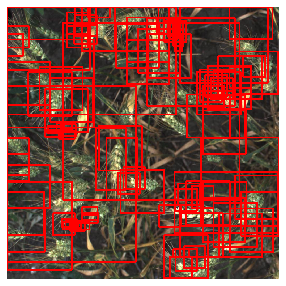

In [45]:
boxes = outputs[0]['boxes'].cpu().numpy()
sample = images[0].permute(1,2,0).cpu().numpy()


fig, ax = plt.subplots(1, figsize=(5,5))

for box in boxes:
    cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  (255, 0, 0),
                  6)
    
ax.set_axis_off()
plt.imshow(sample)

## Train

In [17]:
print(df_train)
print(df_valid)

         image_id                         bbox     x1     y1     x2      y2
0       b6ab77fd7   [834.0, 222.0, 56.0, 36.0]  834.0  222.0  890.0   258.0
1       b6ab77fd7  [226.0, 548.0, 130.0, 58.0]  226.0  548.0  356.0   606.0
2       b6ab77fd7  [377.0, 504.0, 74.0, 160.0]  377.0  504.0  451.0   664.0
3       b6ab77fd7  [834.0, 95.0, 109.0, 107.0]  834.0   95.0  943.0   202.0
4       b6ab77fd7  [26.0, 144.0, 124.0, 117.0]   26.0  144.0  150.0   261.0
...           ...                          ...    ...    ...    ...     ...
122782  97372d371    [59.0, 442.0, 61.0, 58.0]   59.0  442.0  120.0   500.0
122783  97372d371   [30.0, 517.0, 69.0, 105.0]   30.0  517.0   99.0   622.0
122784  97372d371    [0.0, 889.0, 56.0, 121.0]    0.0  889.0   56.0  1010.0
122785  97372d371  [104.0, 872.0, 84.0, 109.0]  104.0  872.0  188.0   981.0
122786  97372d371   [117.0, 975.0, 87.0, 49.0]  117.0  975.0  204.0  1024.0

[122787 rows x 6 columns]
         image_id                          bbox     x1     y1

In [18]:
TRAIN_DIR = '../../data/wheat_detection/train/'
TEST_DIR = '../../data/wheat_detection/test/'

transform = transforms.Compose([
    transforms.ToTensor()
])

def collate_fn(batch):
    return tuple(zip(*batch))

train_data = wheatdataset(df_train, TRAIN_DIR, transform=transform)
valid_data = wheatdataset(df_valid, TRAIN_DIR, transform=transform)

train_loader = DataLoader(train_data, batch_size = 1, shuffle=True, collate_fn=collate_fn)
valid_data = DataLoader(valid_data, batch_size = 4, shuffle=False, collate_fn=collate_fn, num_workers=2)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
import torch.optim as optim

model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [21]:
images

[tensor([[[0.1020, 0.1176, 0.1412,  ..., 0.2824, 0.2902, 0.2980],
          [0.0941, 0.1059, 0.1294,  ..., 0.2667, 0.2706, 0.2706],
          [0.0824, 0.0941, 0.1137,  ..., 0.2588, 0.2588, 0.2588],
          ...,
          [0.2196, 0.2196, 0.2196,  ..., 0.8667, 0.8745, 0.8667],
          [0.2353, 0.2314, 0.2275,  ..., 0.7882, 0.8078, 0.8196],
          [0.2471, 0.2431, 0.2392,  ..., 0.7176, 0.7294, 0.7529]],
 
         [[0.0941, 0.1098, 0.1333,  ..., 0.3804, 0.3804, 0.3765],
          [0.0863, 0.0980, 0.1216,  ..., 0.3608, 0.3608, 0.3608],
          [0.0745, 0.0863, 0.1059,  ..., 0.3529, 0.3529, 0.3529],
          ...,
          [0.2196, 0.2196, 0.2196,  ..., 0.8157, 0.8353, 0.8275],
          [0.2353, 0.2314, 0.2275,  ..., 0.7373, 0.7608, 0.7804],
          [0.2471, 0.2431, 0.2392,  ..., 0.6667, 0.6824, 0.7137]],
 
         [[0.0980, 0.1137, 0.1373,  ..., 0.2667, 0.2667, 0.2667],
          [0.0902, 0.1020, 0.1255,  ..., 0.2588, 0.2510, 0.2510],
          [0.0784, 0.0902, 0.1098,  ...,

In [1]:
train_loss_list = []
for e in range(1):
    model.train()
    train_loss = 0
    for i, (images, targets) in enumerate(train_loader):
        
        images = [img.type(torch.FloatTensor).to(device) for img in images]
        targets = [{k:v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model.to(device)(images, targets)
        
        loss = sum(loss for loss in loss_dict.values())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 40 == 0:
            print('Epoch : [%d/%d] ----- Loss : %0.3f' %(i+1, len(train_loader), loss))
            
    print('Epoch : [%d/%d] ------ Loss : %0.3f' %(i+1, len(train_loader), loss))
    train_loss_list.append(train_loss)    

NameError: name 'model' is not defined